# Imports

In [1]:
# Pandas: DataFrame
import pandas as pd

# Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Sklearn 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Embedding, LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Word2vec
import gensim

# nltk module
import nltk
from  nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

# Utilities
import re
import numpy as np
import os
from collections import Counter
import pickle
import itertools

#  Prefixed Parameters

In [2]:
# Dataset
DATASET_COLUMNS = ["target", "id", "date", "user", "text"]

# Keras
SEQUENCE_LENGTH = 200
EPOCHS = 8
BATCH_SIZE = 300

#Word2Vect
W2V_SIZE = 200
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# Sentiments
SENTIMENTS = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# Exports
KERAS_MODEL = "model.h5"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Dataset details

    target: the polarity of the tweet (negative:0 , positive: 4)
    id:     the id of the tweet
    date:   the date of the tweet (Sat May 16 23:58:44 UTC 2009)
    user:   the user that tweeted
    text:   the text of the tweet



In [3]:
def data_loading(relative_path):
    filenames = os.listdir(relative_path)[0]
    dataset_path = os.path.join(relative_path, filenames)
    df1 = pd.read_csv(dataset_path, encoding ="ISO-8859-1" , skipinitialspace=True, names=DATASET_COLUMNS, nrows=100000)
    df2 = pd.read_csv(dataset_path, encoding ="ISO-8859-1" , skipinitialspace=True, names=DATASET_COLUMNS,skiprows=800000, nrows=100000)
    df = pd.concat([df1, df2])
    return df

In [4]:
df = data_loading("./input")

In [5]:
df.head(6)

,target,id,date,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,@Kwesidei not the whole crew


In [6]:
df.tail(5)

,target,id,date,user,text
99995,4,1693956088,Mon May 04 00:27:13 PDT 2009,FelineBred,"@jvdouglas haha, no, the remark on maternity ..."
99996,4,1693956096,Mon May 04 00:27:14 PDT 2009,softthistle,@altitis and to you!
99997,4,1693956099,Mon May 04 00:27:14 PDT 2009,elysion32,Okie doke!! Time for me to escape for the Nort...
99998,4,1693956134,Mon May 04 00:27:14 PDT 2009,fancyjessy,"finished the lessons, hooray!"
99999,4,1693956160,Mon May 04 00:27:14 PDT 2009,noraezan,Some ppl are just fucking KP0. Cb ! Stop askin...


In [7]:
print("Dataset size:", len(df))

Dataset size: 200000


In [113]:
class Visualize:
    
    @classmethod
    def plot_bar(self, target):
        dict_target = Counter(df.target) # Counter(['a','a','b','a']) => returns {'a': 3, 'b': 1}
        plt.figure(figsize=(16,8))
        plt.bar(dict_target.keys(), dict_target.values())
        plt.title("Dataset labels distribuition")
        
    @classmethod
    def plot_accuracy(self, history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(len(acc))
        f = plt.figure(figsize=(16,5))
        ax1 = f.add_subplot(121)
        ax2 = f.add_subplot(122)

        ax1.plot(epochs, acc, 'b', label='Training acc')
        ax1.plot(epochs, val_acc, 'r', label='Validation acc')
        ax1.set_title('Training and validation accuracy')
        ax1.legend()

        ax2.plot(epochs, loss, 'b', label='Training loss')
        ax2.plot(epochs, val_loss, 'r', label='Validation loss')
        ax2.set_title('Training and validation loss')
        ax2.legend()
        plt.show()
    
    @classmethod
    def plot_confusion_matrix(self, cnf_matrix):
        f = plt.figure(figsize=(14,10))
        ax = f.add_subplot()
        sns.heatmap(cnf_matrix, annot=True, ax = ax)
        ax.set_xlabel('Predicted labels', fontsize=28)
        ax.set_ylabel('True labels', fontsize=28) 
        ax.set_title('Confusion Matrix',fontsize=40)
        ax.xaxis.set_ticklabels(['POSITIVE','NEGATIVE'], rotation=90, fontsize=25)
        ax.yaxis.set_ticklabels(['POSITIVE','NEGATIVE'],rotation=360, fontsize=25)
        plt.show()
    
    @classmethod
    def plot_displot(self,df):
        Y = df["date"].str[8:10].astype(int)
        Z = df["date"].str[4:10] 
        s = sns.displot(df, x="target", y=Y, hue=Z, binwidth=(2, 2))
        plt.yticks([1,2,6,7,17,18,19,20,21])
        plt.ylabel("Time (24h)")
        plt.xlabel("Sentiment")
        plt.title("Distribution of sentiments across 24h for specific dates")
        plt.show()
        
    
    @classmethod
    def most_frequent_words(self, documents):
        document = [word for i in range(len(documents)) for word in documents[i]]
        word_frequency = Counter(document)
        k = sorted(word_frequency, key=word_frequency.get, reverse=True)[:10]
        print(k)
        
    @classmethod
    def get_accuracy(self,y_test, y_pred):
        print(accuracy_score(y_test, y_pred))
    
    @classmethod
    def classification_report(self, y_true, y_predicted):
        print(classification_report(y_true, y_predicted))

In [9]:
class Preprocessing:
    
    @classmethod
    def _decode_sentiment(self, target):
        def _getLabel(label):
            return SENTIMENTS[int(label)]
        return target.apply(lambda x: _getLabel(x))
    
    @classmethod
    def _data_preprocessing(self, text):
        def clean_text(text):
            stop_words = stopwords.words("english")
            stemmer = SnowballStemmer("english")
            # Remove link and numbers, special characters
            text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+|\d+", ' ', str(text).lower()).strip()
            words = []
            for word in text.split():
                if word not in stop_words:
                    #Stemmers remove morphological affixes from words, leaving only the word stem.
                    words.append(stemmer.stem(word)) 
            return " ".join(words)
        return text.apply(lambda x: clean_text(x))   

# Preprocessing phase

In [10]:
df.target = Preprocessing._decode_sentiment(df.target)
df.target[:3]

0    NEGATIVE
1    NEGATIVE
2    NEGATIVE
Name: target, dtype: object

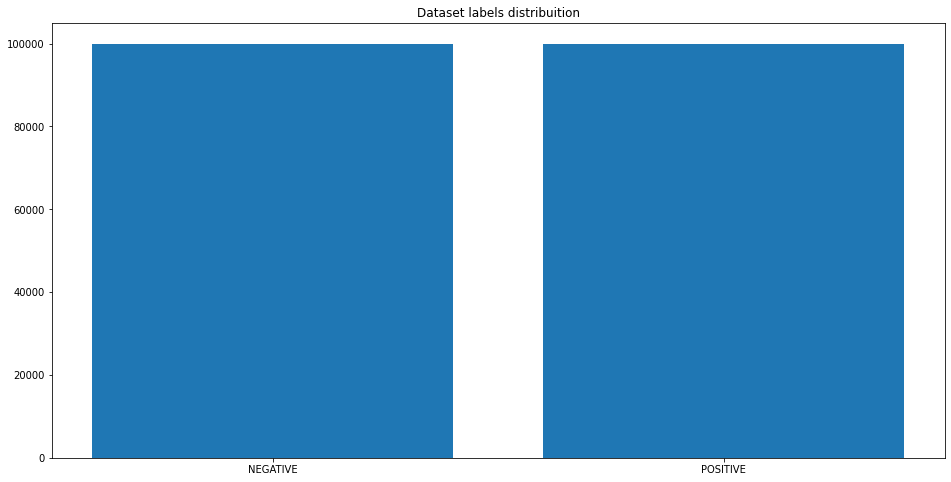

In [11]:
Visualize.plot_bar(df.target)

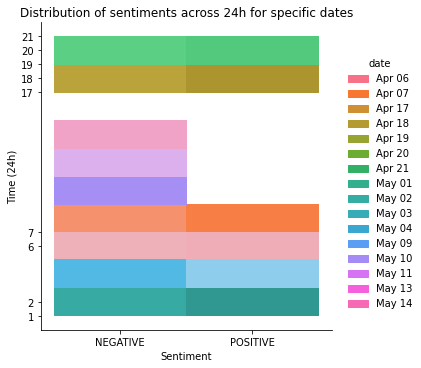

In [12]:
Visualize.plot_displot(df)

In [13]:
df.text = Preprocessing._data_preprocessing(df.text)
df.text[20:30]

20                                    day get much done
21    one friend call ask meet mid valley today time...
22                                        bake cake ate
23                                         week go hope
24                                 blagh class tomorrow
25                                 hate call wake peopl
26                            go cri sleep watch marley
27                                    im sad miss lilli
28                     ooooh lol lesli ok lesli get mad
29    meh almost lover except track get depress ever...
Name: text, dtype: object

In [14]:
df.isnull().sum()

target    0
id        0
date      0
user      0
text      0
dtype: int64

# Split train and test

In [15]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
print("Train size:", len(df_train))
print("Test size:", len(df_test))

Train size: 160000
Test size: 40000


# Word2Vec

Word2Vec can be used to find the relations between words in a dataset, compute the similarity between them, or use the vector representation of those words as input for other applications such as text classification like in our case.

In [16]:
documents = [_text.split() for _text in df_train.text] 
documents[0:2]

[['club',
  'slower',
  'usual',
  'nite',
  'vibe',
  'incred',
  'real',
  'happi',
  'ubzz',
  'divers',
  'set',
  'threw',
  'dj'],
 ['pleas', 'tell', 'dame', 'isnt', 'rap', 'lemm', 'see', 'cover', 'whenev']]

In [17]:
Visualize.most_frequent_words(documents)

['go', 'day', 'get', 'good', 'work', 'like', 'love', 'today', 'quot', 'time']


### I seperated the training of the model in 3 steps for clarity:
1- setting up Word2Vec parameters:<br>
       I have set up the model parameters one-by-one in this first step.
      
    
2- build_vocab<br>
       This builds the vocabulary from a collection of sentences and hence initializes the model. 
    
3- train<br>
       Eventually, the model training. 


### Description of parameters

window -> int : Represents the maximum distance between the current and predicted word within a sentence.<br>
min_count: -> int : Ignores all words with absolute total frequency lower than min_count parameter.<br>
size -> int : Represents the dimensionality of the feature vectors.<br>
workers -> int : number of worker-threads to train the model.<br>


In [18]:
import multiprocessing
print(f"my pc has: {multiprocessing.cpu_count()} cores")

my pc has: 12 cores


In [19]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=11)

In [20]:
w2v_model.build_vocab(documents, progress_per=10000)

In [21]:
w2v_model.train(documents, total_examples=w2v_model.corpus_count, epochs=W2V_EPOCH)

(29854103, 36029312)

In [22]:
w2v_model.most_similar("love")

<ipython-input-22-9e1a4c826e7b>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v_model.most_similar("love")


[('awsom', 0.4674363434314728),
 ('luv', 0.4454992413520813),
 ('amaz', 0.398148775100708),
 ('awesom', 0.39132437109947205),
 ('jonasbroth', 0.37164437770843506),
 ('lovin', 0.34920457005500793),
 ('mariah', 0.34891924262046814),
 ('great', 0.3485202491283417),
 ('lovee', 0.33876633644104004),
 ('ador', 0.33693361282348633)]

In [23]:
w2v_model.wv["hello"]

array([ 1.5972192 ,  1.0236028 ,  0.29360062, -2.3576953 , -0.8104026 ,
       -0.21374042, -1.2245867 , -0.51240546,  0.95114225, -0.7365406 ,
       -0.21174094, -0.33666667,  0.5845366 ,  0.92113817,  0.9962211 ,
       -0.56285197,  0.7752473 ,  1.6728182 , -0.9624558 , -0.46202782,
       -0.54469466, -0.4853729 ,  1.7273546 ,  0.22486146, -1.5046512 ,
        0.96058667, -0.6680073 , -2.8639636 ,  1.5655768 , -0.40725192,
        0.07499909,  0.84226215, -1.3518114 , -1.2019107 , -0.66562337,
       -0.5165853 ,  1.0350541 , -0.20363854, -1.6506441 ,  1.9267497 ,
        0.43774104,  1.8512762 ,  0.74954   ,  0.6327625 , -0.00484158,
       -0.4906937 , -1.4513677 , -0.30858752, -0.88469183, -1.153848  ,
       -0.69359165, -0.8582059 ,  1.207291  ,  0.6816094 , -0.47027168,
       -0.9519814 ,  0.7311964 , -0.6896069 ,  1.738748  ,  0.38391307,
        1.4268942 , -0.57446027,  0.24002989, -0.64661306, -0.57066983,
       -0.97304577,  0.08752079, -1.0077964 , -0.09991288, -0.23

In [24]:
# w2v_model.save("model.w2v")

# Classifier Part

In [25]:
def transform_X(df_train, df_test):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df_train.text) 
#     1- tokenizer.fit_on_texts("The earth is an awesome place live") fits [[1,2,3,4,5,6,7]] 
#     where 3 -> "is" , 6 -> "place", so on.
#     2- texts_to_sequences: Does the same thing as fir_on_text but Only words known by the tokenizer 
#     will be taken into account.
#     3- pad_sequences: transforms a list (of length num_samples) of sequences (lists of integers) 
#     into a 2D Numpy array of shape (num_samples, num_timesteps), num_timsteps is the maxlen argument in our case
    x_fit_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=200)
    x_fit_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=200)
    return x_fit_train, x_fit_test, tokenizer

In [26]:
def transform_Y(df_train, df_test):
    encoder = LabelEncoder()
    encoder.fit(df_train.target.tolist())
#     LabelEncoder : Encode target labels Y with value between 0 and n_classes-1

    y_train = encoder.transform(df_train.target.tolist()).reshape(-1,1)
    y_test = encoder.transform(df_test.target.tolist()).reshape(-1,1)
    
    return y_train, y_test, encoder
    

In [27]:
x_fit_train, x_fit_test, tokenizer = transform_X(df_train, df_test)

In [28]:
# pickle.dump(tokenizer, open("tokenizer.pkl", "wb"), protocol=0)

In [29]:
y_fit_train, y_fit_test, encoder = transform_Y(df_train, df_test)

In [30]:
# pickle.dump(encoder, open("encoder.pkl", "wb"), protocol=0)

In [31]:
y_fit_train

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

### Building the Embedding layer

In [32]:
vocab_size = len(tokenizer.word_index) + 1

In [33]:
def embedding_matrix(tokenizer, w2v_model):
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]
    return embedding_matrix

In [34]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix(tokenizer, w2v_model)], input_length=SEQUENCE_LENGTH, trainable=False)

## Build model 

In [35]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 200)          11480800  
_________________________________________________________________
dropout (Dropout)            (None, 200, 200)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 11,601,301
Trainable params: 120,501
Non-trainable params: 11,480,800
_________________________________________________________________


### Model compile

In [36]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [37]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Model train

In [38]:
history = model.fit(x_fit_train, y_fit_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
480/480 [==============================] - 349s 722ms/step - loss: 0.5770 - accuracy: 0.6912 - val_loss: 0.5588 - val_accuracy: 0.6989
Epoch 2/8
480/480 [==============================] - 676s 1s/step - loss: 0.5501 - accuracy: 0.7202 - val_loss: 0.5013 - val_accuracy: 0.7511
Epoch 3/8
480/480 [==============================] - 751s 2s/step - loss: 0.5242 - accuracy: 0.7366 - val_loss: 0.4961 - val_accuracy: 0.7570
Epoch 4/8
480/480 [==============================] - 583s 1s/step - loss: 0.5109 - accuracy: 0.7468 - val_loss: 0.4995 - val_accuracy: 0.7591
Epoch 5/8
480/480 [==============================] - 380s 792ms/step - loss: 0.5081 - accuracy: 0.7467 - val_loss: 0.4952 - val_accuracy: 0.7597
Epoch 6/8
480/480 [==============================] - 412s 859ms/step - loss: 0.5051 - accuracy: 0.7498 - val_loss: 0.4953 - val_accuracy: 0.7640
Epoch 7/8
480/480 [==============================] - 355s 741ms/step - loss: 0.4995 - accuracy: 0.7540 - val_loss: 0.4918 - val_accuracy: 0

In [39]:
# model.save("model.h5")

In [40]:
def predict(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
#     x_test = w2v_model.wv[text]
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    if score <= SENTIMENT_THRESHOLDS[0]:
        return "NEGATIVE"
    elif score >= SENTIMENT_THRESHOLDS[1]:
        return "POSITIVE"
    else:
        return "NEUTRAL"

In [41]:
score = model.evaluate(x_fit_test, y_fit_test, batch_size=BATCH_SIZE)
print(f"Accuracy: {score[1]}\t\t Loss: {score[0]}")


134/134 [==============================] - 24s 177ms/step - loss: 0.4889 - accuracy: 0.7664
Accuracy: 0.7663999795913696		 Loss: 0.48891010880470276


In [42]:
predict("I love listening to music")

'POSITIVE'

## Perfaormance mesure

In [43]:
from sklearn.metrics import multilabel_confusion_matrix

In [44]:
decode = lambda score: "NEGATIVE" if score < 0.5 else "POSITIVE"

In [115]:
y_true = list(df_test.target)
scores = model.predict(x_fit_test, batch_size=200)
y_predicted = [decode(score) for score in scores]

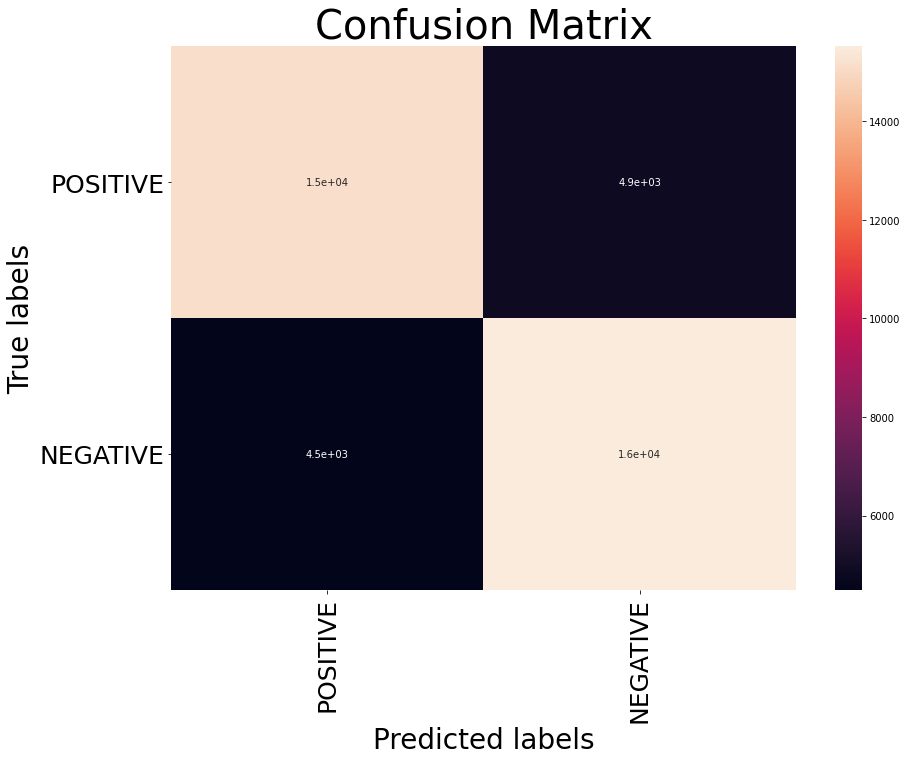

In [116]:
cnf_matrix = confusion_matrix(y_true, y_predicted)
Visualize.plot_confusion_matrix(cnf_matrix)

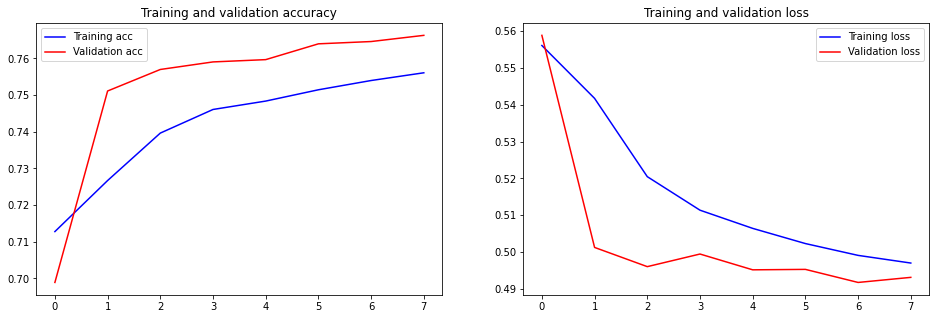

In [47]:
Visualize.plot_accuracy(history)

In [48]:
Visualize.get_accuracy(y_true, y_predicted)

0.7664


In [49]:
Visualize.classification_report(y_true, y_predicted)

              precision    recall  f1-score   support

    NEGATIVE       0.77      0.76      0.76     19993
    POSITIVE       0.76      0.78      0.77     20007

    accuracy                           0.77     40000
   macro avg       0.77      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000

